### Eigenvector analysis of immune cells dataset

Low-resolution demonstration of the projection to the consensus.

Consensus is computed with STATIS joint matrix decomposition (Abdi, 2012), which weights each trans Hi-C matrix accoring to how much is resembles the representative dataset, and calcaulated consensus principal components. 

Then each trans Hi-C matrix is projected onto the consensus and weighted by the variance explained by component, allowing comparison of the same components projections between different Hi-C experiments.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import joint_lib

In [3]:
import sys
sys.path.append('/home/agalicina/soft/sandbox/pySTATIS')

In [16]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot

# Plotting parameters:
proplot.rc['figure.facecolor'] = 'white'
proplot.rc.update(
    linewidth=1, fontsize=10,
    color='dark blue', suptitlecolor='dark blue',
    titleloc='upper center', titlecolor='dark blue', titleborder=False,
)
mpl.rcParams['font.sans-serif'] = "Arial" # Set the font
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['grid.alpha'] = 0 # Remove the grid
mpl.rcParams['xtick.minor.bottom'] = False # Remove minor ticks
mpl.rcParams['ytick.minor.left'] = False
mpl.rcParams['ytick.minor.right'] = False

import warnings
warnings.filterwarnings('ignore')

import bioframe
import cooler

In [9]:
N_EIGS = 128
CHROMSIZES = bioframe.fetch_chromsizes('mm10', filter_chroms=True)
CHROMOSOMES = list(CHROMSIZES[:'chrY'].index)
BINSIZE = 1_000_000
chunksize = 2000000

COOLER_PATHS = {
    'undiff_unstim': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library_group/undiff_unstim.mm10.mapq_30.1000.mcool',
    'cDC_unstim': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library_group/cDC_unstim.mm10.mapq_30.1000.mcool',
    'pDC_unstim': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library_group/pDC_unstim.mm10.mapq_30.1000.mcool',
    'pDC_CpGA': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library_group/pDC_CpGA.mm10.mapq_30.1000.mcool',

    'IRF8KO': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/IRF8KO_HoxB8.mm10.mapq_30.1000.mcool',
    'SMC3KO_cDC': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/SMC3KO_cDC.mm10.mapq_30.1000.mcool',
    'SMC3KO_pDC': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/SMC3KO_pDC.mm10.mapq_30.1000.mcool',
    'WT_cDC': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/WT_cDC.mm10.mapq_30.1000.mcool',
    'WT_pDC': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library_group/WT_pDC.mm10.mapq_30.1000.mcool',
    
    'cDC_unstim_R1': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/cDC_unstim_01_S2.mm10.mapq_30.1000.mcool',
    'cDC_unstim_R2': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/cDC_unstim_02_S6.mm10.mapq_30.1000.mcool',
    'pDC_CpGA_R1': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/pDC_CpGA_01_S4.mm10.mapq_30.1000.mcool',
    'pDC_CpGA_R2': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/pDC_CpGA_02_S8.mm10.mapq_30.1000.mcool',
    'pDC_unstim_R1': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/pDC_unstim_01_S3.mm10.mapq_30.1000.mcool',
    'pDC_unstim_R2': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/pDC_unstim_02_S7.mm10.mapq_30.1000.mcool',
    'undiff_unstim_R1': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/undiff_unstim_01_S1.mm10.mapq_30.1000.mcool',
    'undiff_unstim_R2': '/net/levsha/share/lab/reizis2020/disiller_0.3.3-mm10/results/coolers_library/undiff_unstim_02_S5.mm10.mapq_30.1000.mcool',
    'IRF8KO_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/IRF8KO_HoxB8_01_S9.mm10.mapq_30.1000.mcool',
    'IRF8KO_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/IRF8KO_HoxB8_02_S10.mm10.mapq_30.1000.mcool',
    'SMC3KO_cDC_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/SMC3KO_cDC_01_S5.mm10.mapq_30.1000.mcool',
    'SMC3KO_cDC_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/SMC3KO_cDC_02_S6.mm10.mapq_30.1000.mcool',
    'SMC3KO_pDC_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/SMC3KO_pDC_01_S7.mm10.mapq_30.1000.mcool',
    'SMC3KO_pDC_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/SMC3KO_pDC_02_S8.mm10.mapq_30.1000.mcool',
    'WT_cDC_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/WT_cDC_01_S1.mm10.mapq_30.1000.mcool',
    'WT_cDC_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/WT_cDC_02_S2.mm10.mapq_30.1000.mcool',
    'WT_pDC_R1': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/WT_pDC_01_S3.mm10.mapq_30.1000.mcool',
    'WT_pDC_R2': '/net/levsha/share/lab/reizis2020/distiller_0.3.3-mm10_mutants/results/coolers_library/WT_pDC_02_S4.mm10.mapq_30.1000.mcool',

    }

CONDITIONS = [
    'undiff_unstim',
    'cDC_unstim',
    'pDC_unstim',
    'pDC_CpGA',
    'IRF8KO',
    'SMC3KO_cDC',
    'SMC3KO_pDC',
    'WT_cDC',
    'WT_pDC',
    # 'cDC_unstim_R1', 
    # 'cDC_unstim_R2', 
    # 'pDC_CpGA_R1', 
    # 'pDC_CpGA_R2', 
    # 'pDC_unstim_R1', 
    # 'pDC_unstim_R2', 
    # 'undiff_unstim_R1', 
    # 'undiff_unstim_R2', 
    # 'IRF8KO_R1', 
    # 'IRF8KO_R2', 
    # 'SMC3KO_cDC_R1', 
    # 'SMC3KO_cDC_R2', 
    # 'SMC3KO_pDC_R1', 
    # 'SMC3KO_pDC_R2', 
    # 'WT_cDC_R1', 
    # 'WT_cDC_R2', 
    # 'WT_pDC_R1', 
    # 'WT_pDC_R2',
]

In [10]:
COOLERS_DICT = joint_lib.read_coolers(COOLER_PATHS, CONDITIONS, BINSIZE, CHROMOSOMES)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.24s/it, WT_pDC]


In [11]:
JOINT_MTX, GOOD_BINS = joint_lib.list_to_filtered_array(COOLERS_DICT, conditions=CONDITIONS, backend='STATIS', norm=None)

undiff_unstim
        zeros ratio before zero rows removal: 19.65% 
        zeros ratio after zero rows removal: 0.05%
        
cDC_unstim
        zeros ratio before zero rows removal: 19.24% 
        zeros ratio after zero rows removal: 0.05%
        
pDC_unstim
        zeros ratio before zero rows removal: 18.00% 
        zeros ratio after zero rows removal: 0.04%
        
pDC_CpGA
        zeros ratio before zero rows removal: 18.79% 
        zeros ratio after zero rows removal: 0.04%
        
IRF8KO
        zeros ratio before zero rows removal: 18.26% 
        zeros ratio after zero rows removal: 0.05%
        
SMC3KO_cDC
        zeros ratio before zero rows removal: 17.65% 
        zeros ratio after zero rows removal: 0.15%
        
SMC3KO_pDC
        zeros ratio before zero rows removal: 17.31% 
        zeros ratio after zero rows removal: 0.15%
        
WT_cDC
        zeros ratio before zero rows removal: 16.57% 
        zeros ratio after zero rows removal: 0.18%
        
WT_pDC


In [12]:
OUTPUT_STATIS = joint_lib.run_pySTATIS(JOINT_MTX, N_EIGS)

Generating affinity matrices...
undiff_unstim... Done.
cDC_unstim... Done.
pDC_unstim... Done.
pDC_CpGA... Done.
IRF8KO... Done.
SMC3KO_cDC... Done.
SMC3KO_pDC... Done.
WT_cDC... Done.
WT_pDC... Done.
Stack datasets for GSVD...Done!
Getting indices... Done!
Observation masses: Done!
Rv-PCA
Rv-PCA: Hilbert-Schmidt inner products... Done!
Rv-PCA: Decomposing the inner product matrix... Done!
Rv-PCA: Done!
Dataset/variable masses... GSVD
GSVD: Weights... Done!
GSVD: SVD... Done!
GSVD: Factor scores and eigenvalues... Done!
Factor scores for observations... Done!
Calculating factor scores for datasets... Done!
Calculating contributions of observations... .Done!
Calculating contributions of variables... Done!
Calculating contributions of datasets... Done!
Calculating partial inertias for the datasets... Done!
STATIS finished successfully in 71.079 seconds


Eigenvalues (D) plot


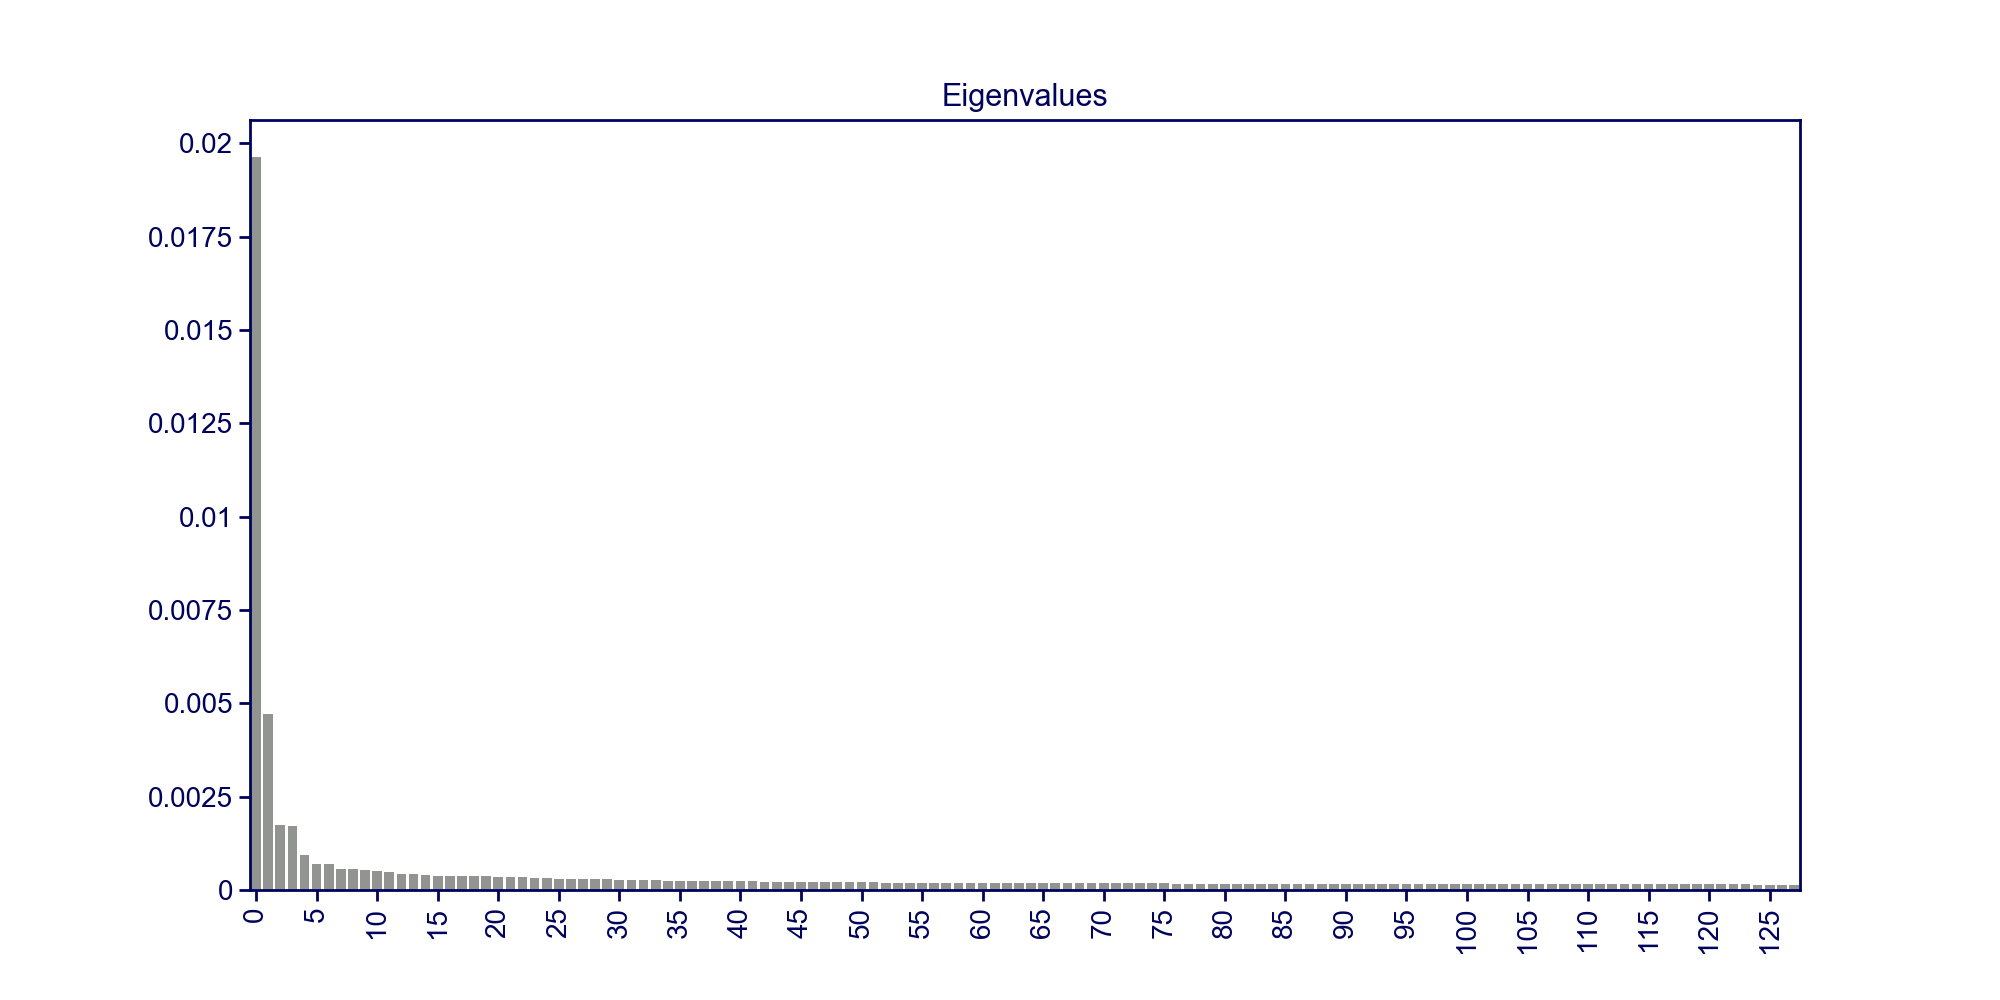

Percentage of variance explained:
[9.12276851e+01 5.24802206e+00 7.26883014e-01 6.96689059e-01
 2.05615090e-01 1.18550155e-01 1.17720402e-01 7.82926333e-02
 7.54026886e-02 6.74282490e-02]
Component   % var     % cumulative
001         91.228     91.228
002         5.248     96.476
003         0.727     97.203
004         0.697     97.900
005         0.206     98.106
006         0.119     98.225
007         0.118     98.343
008         0.078     98.421
009         0.075     98.496
010         0.067     98.563
011         0.064     98.627
012         0.056     98.683
013         0.044     98.727
014         0.041     98.768
015         0.039     98.807
016         0.035     98.842
017         0.033     98.875
018         0.032     98.907
019         0.032     98.939
020         0.031     98.970
021         0.030     99.000
022         0.029     99.029
023         0.027     99.056
024         0.025     99.081
025         0.024     99.105
026         0.021     99.126
027         0.021     

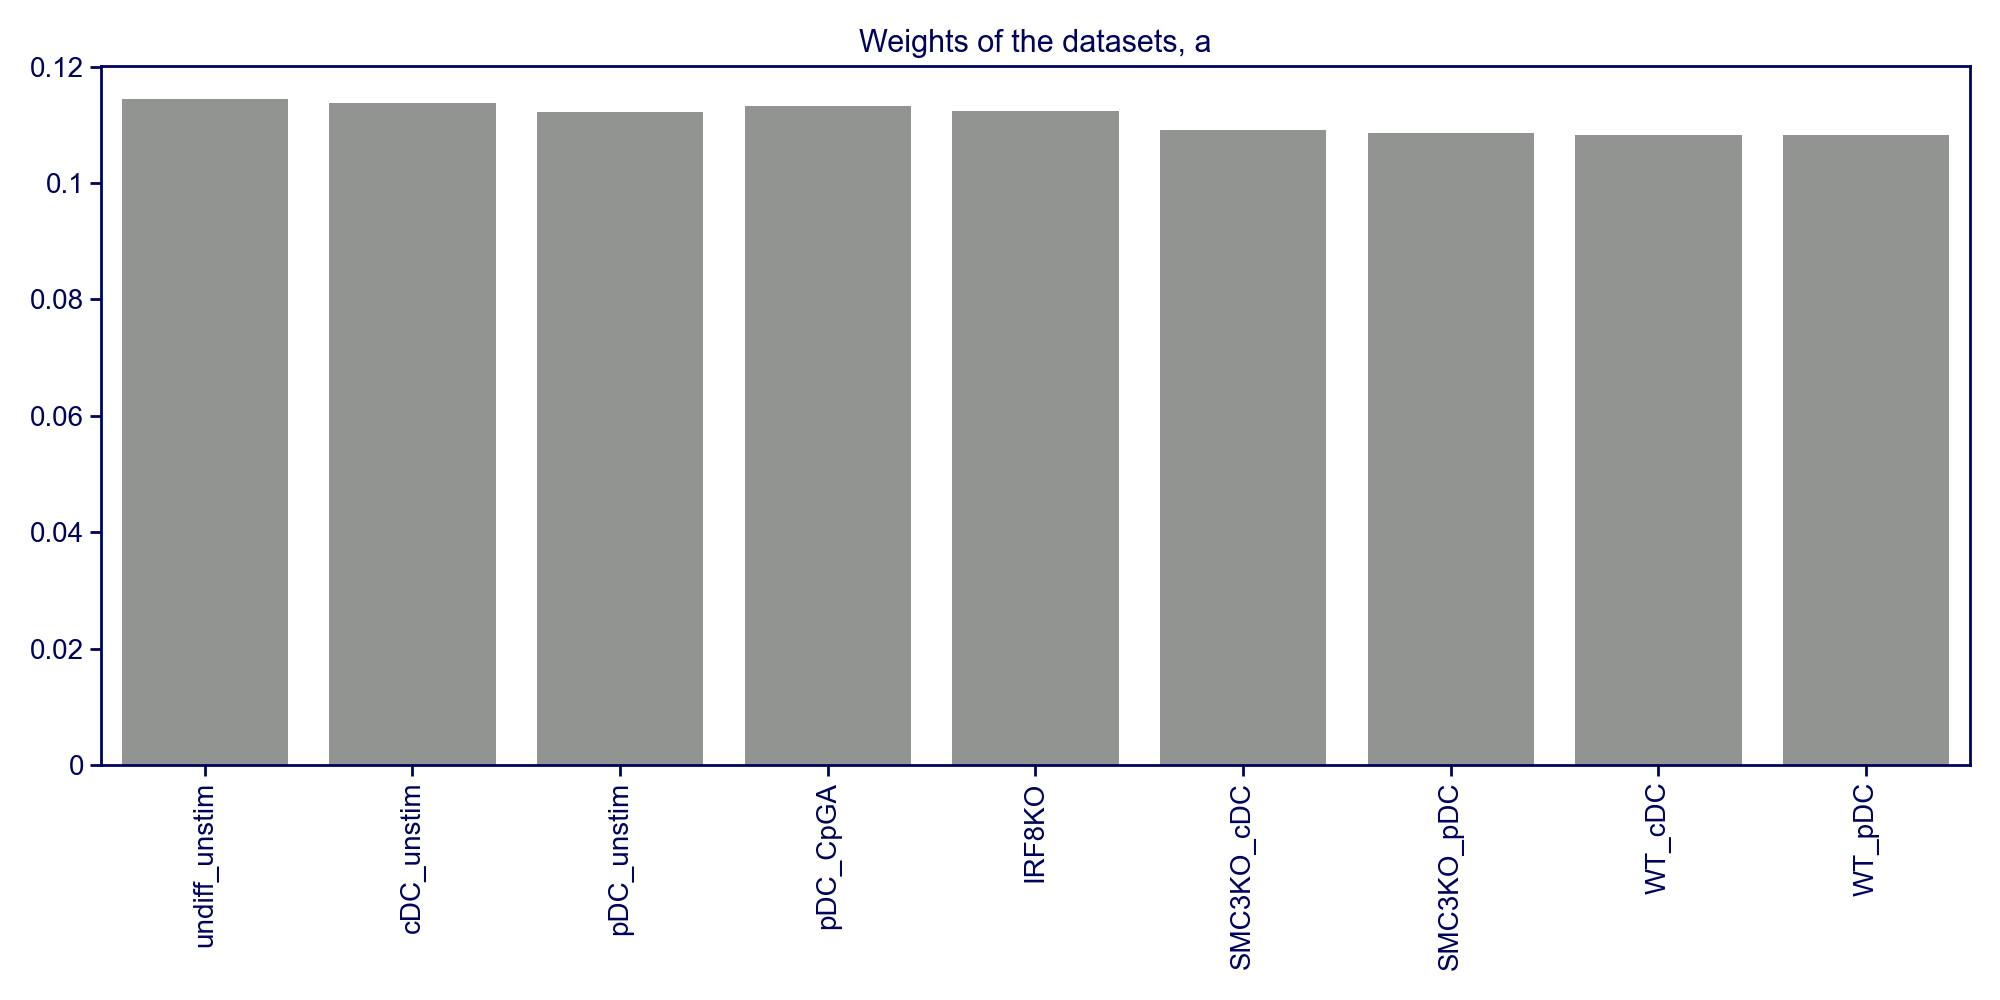

Heatmap of contributions of datasets to components


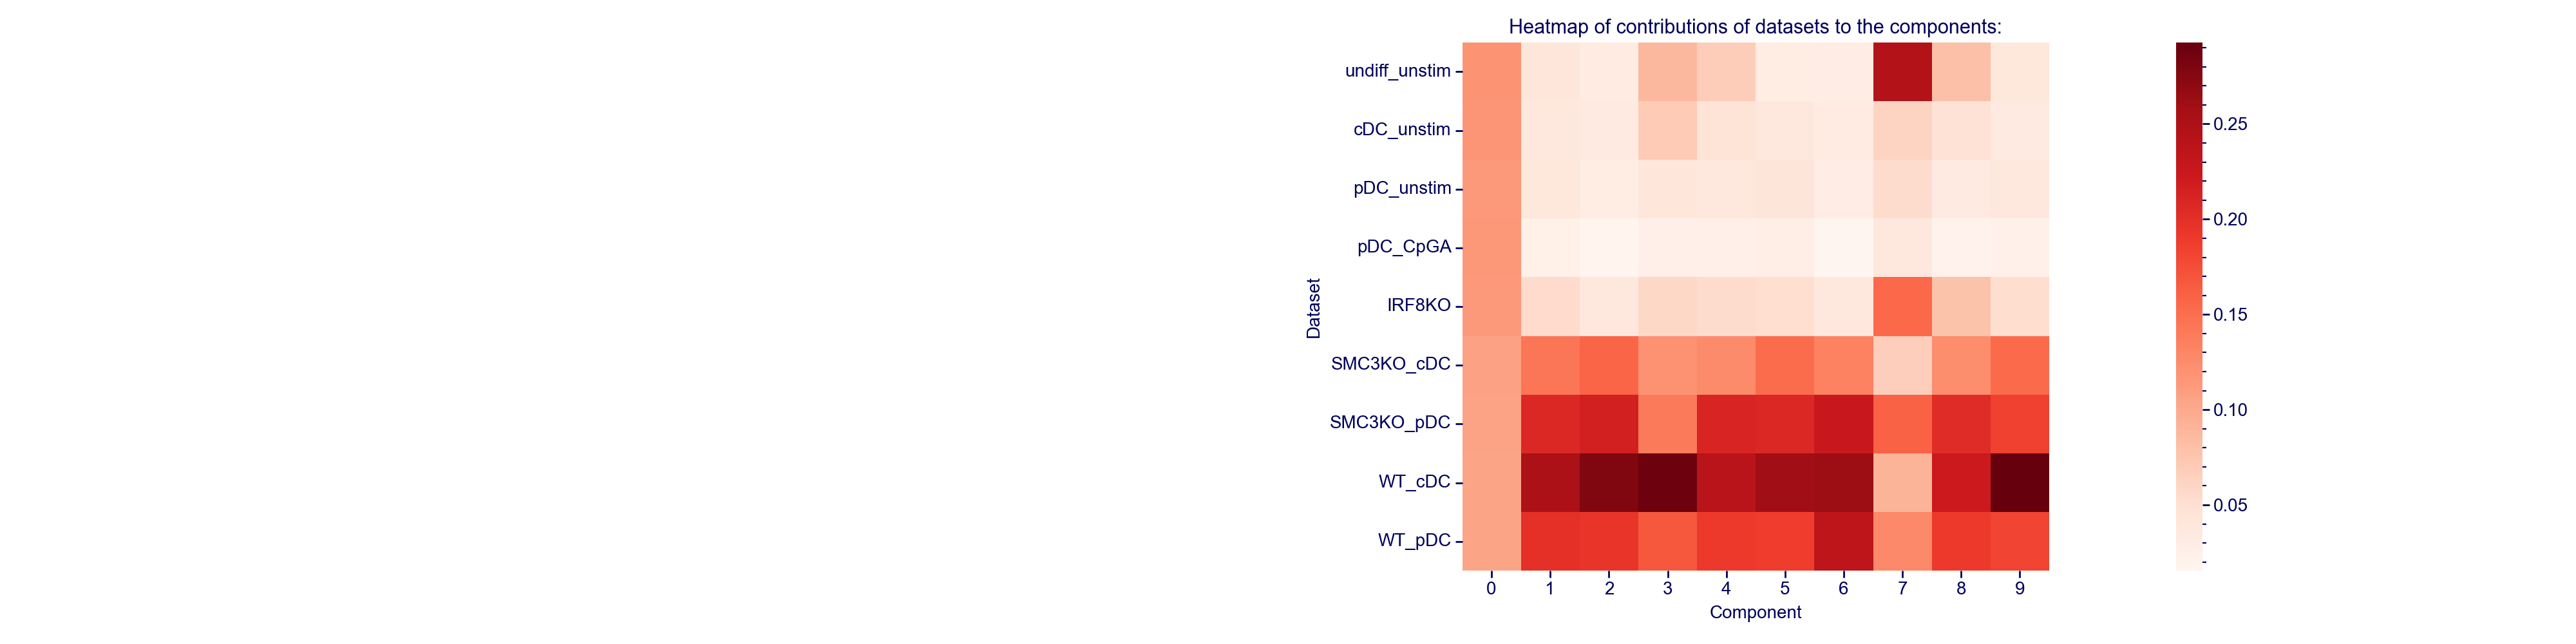

Contributions of genomic positions per component
Contribution of genomic positions per dataset into component 1
Quick scatterplots of loadings
Quick scatterplots of factor scores


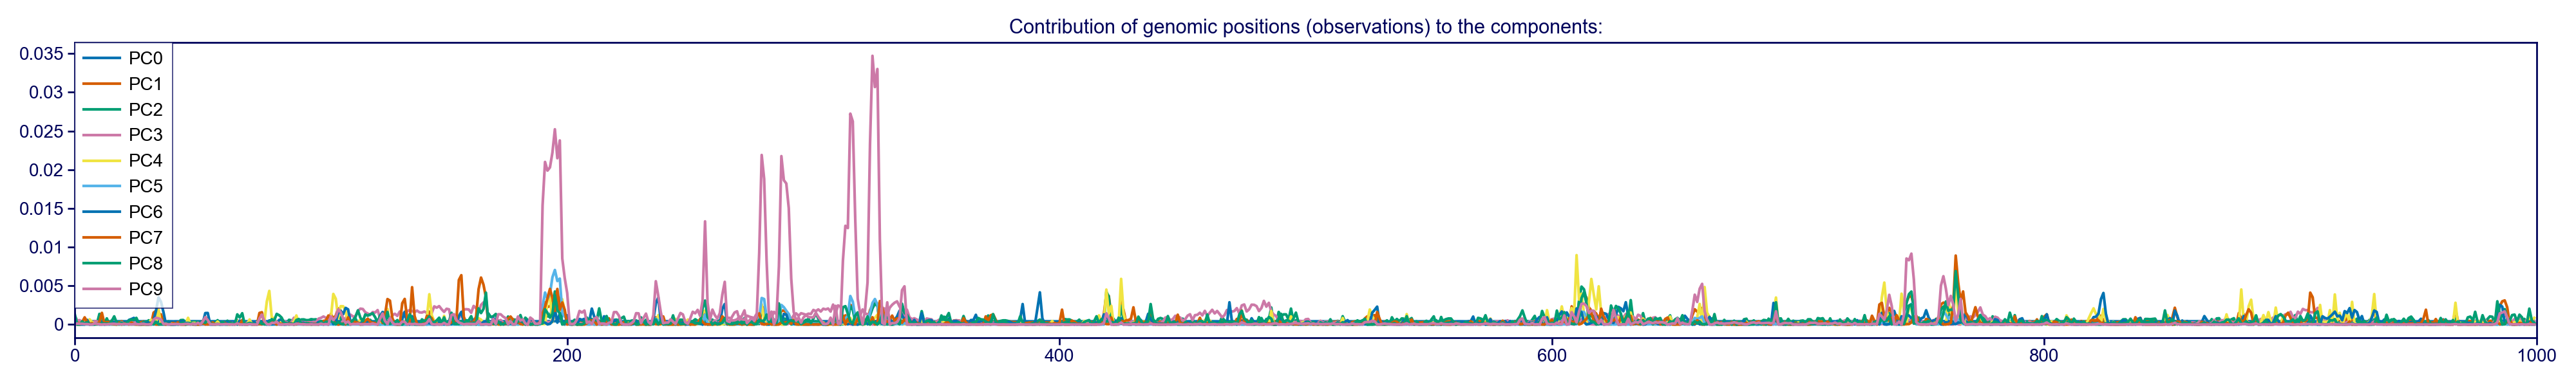

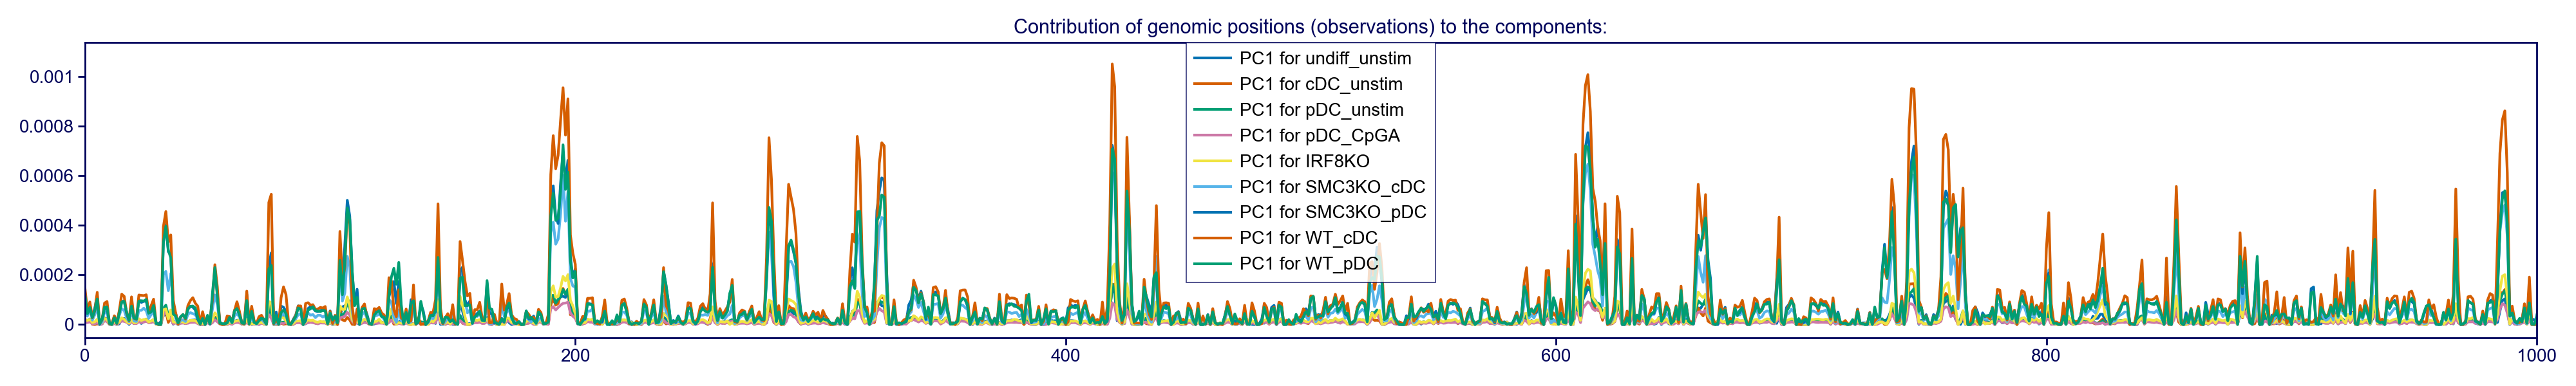

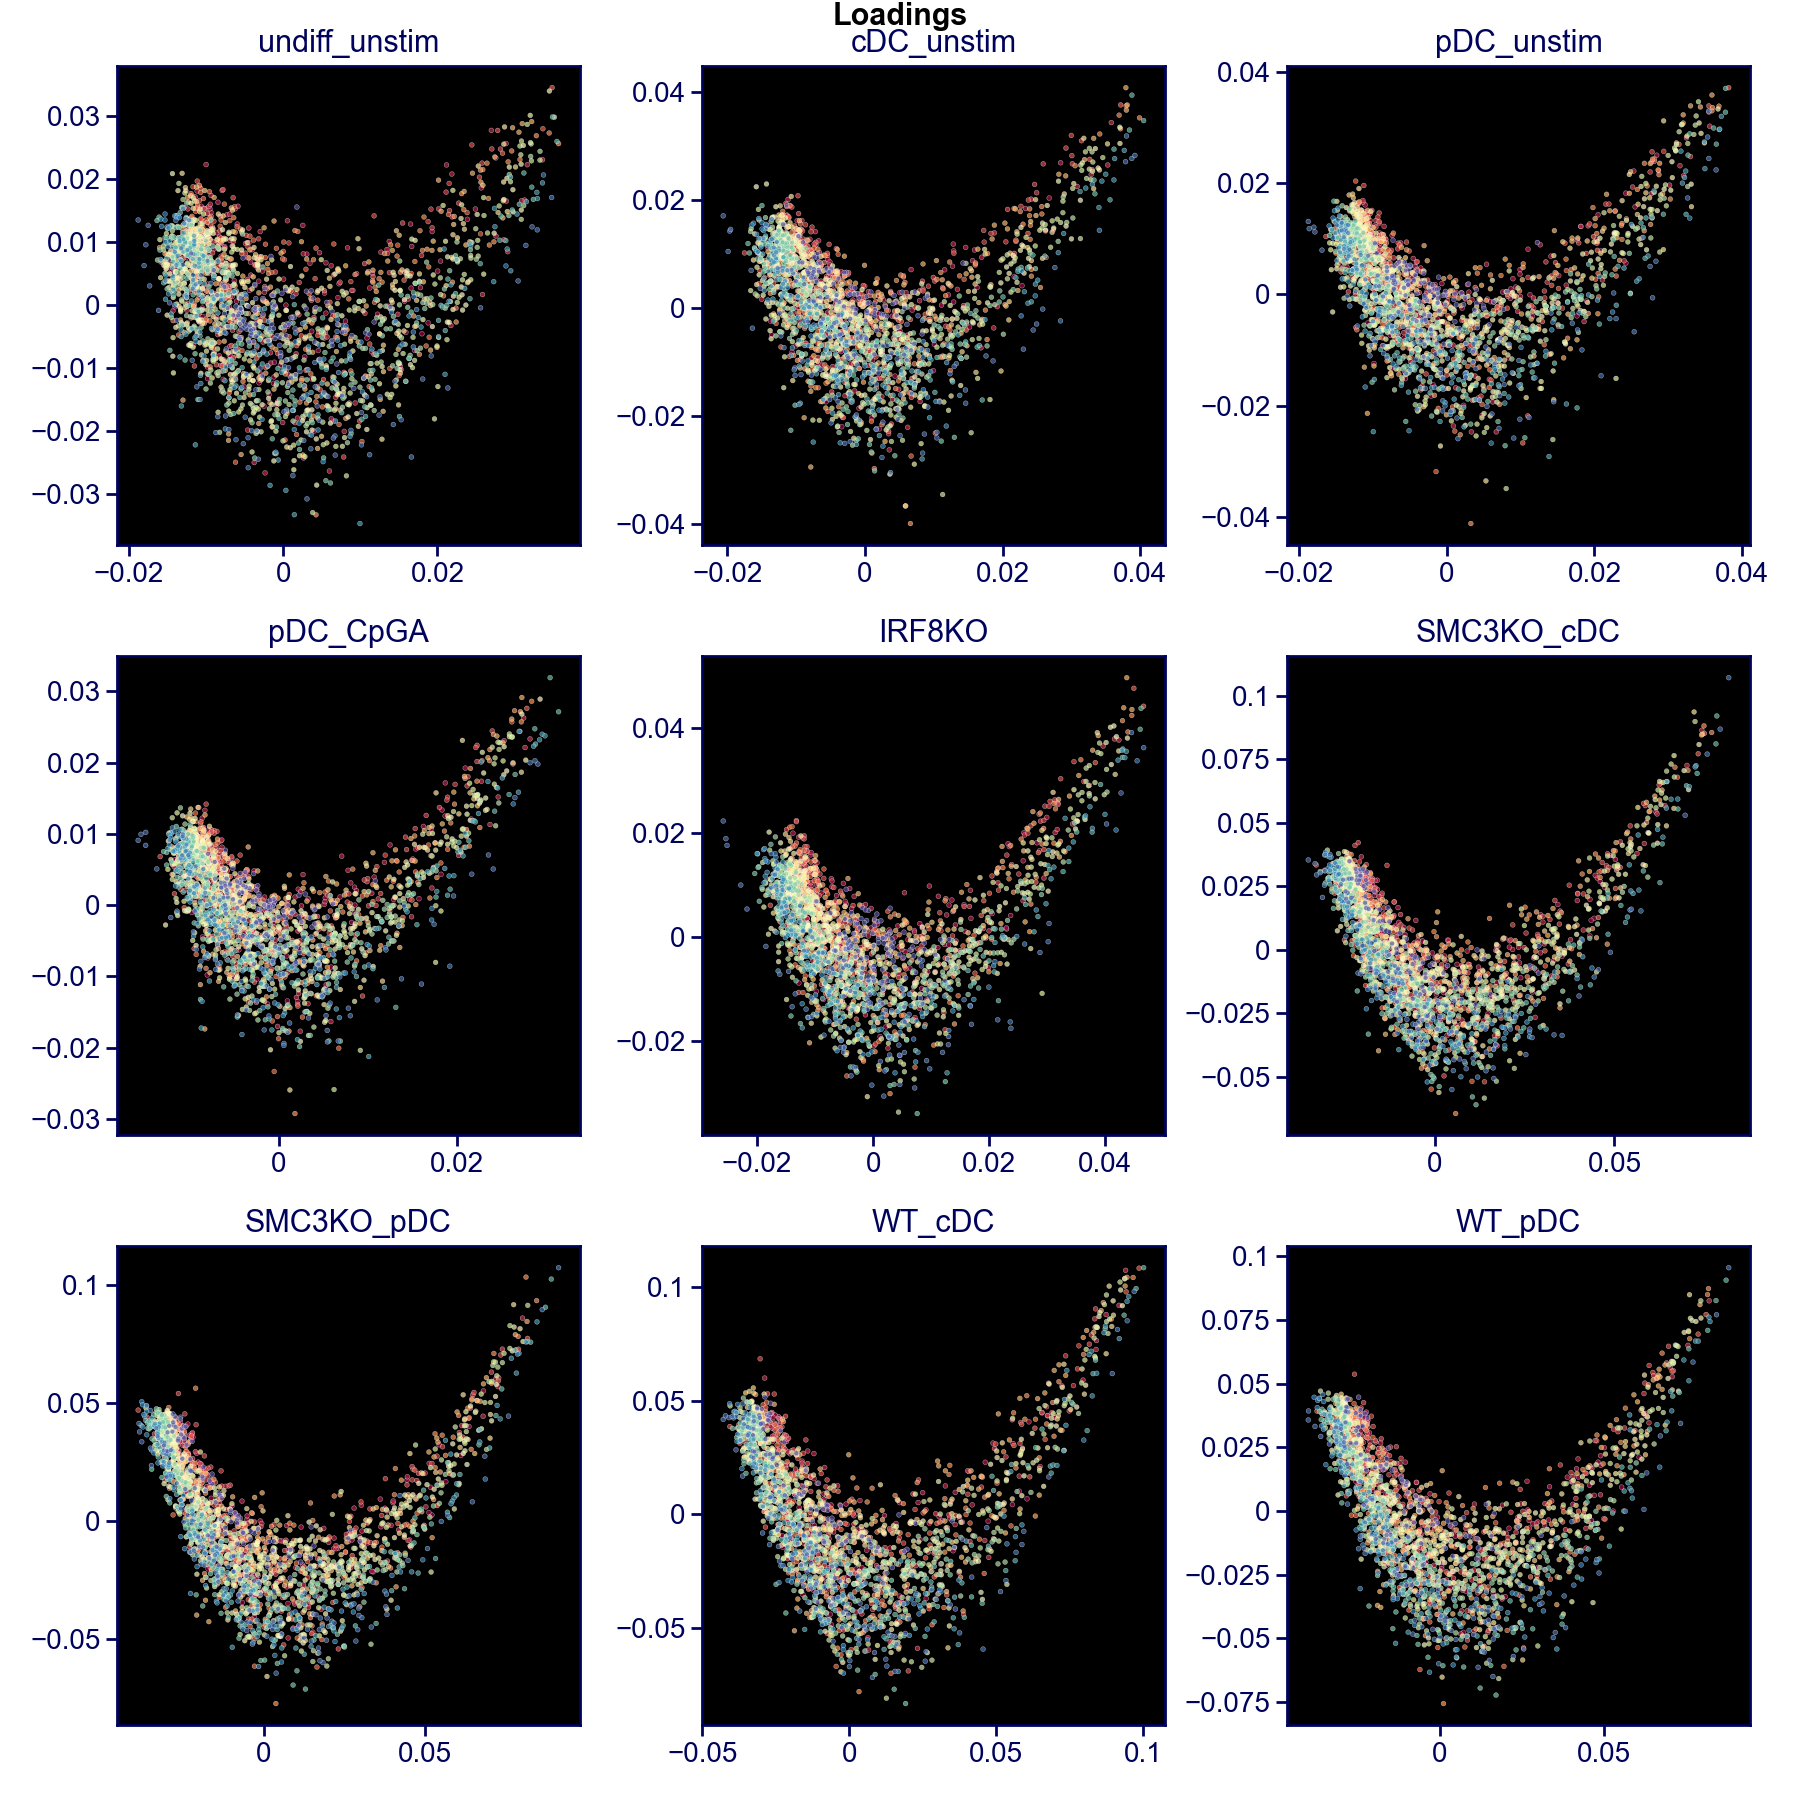

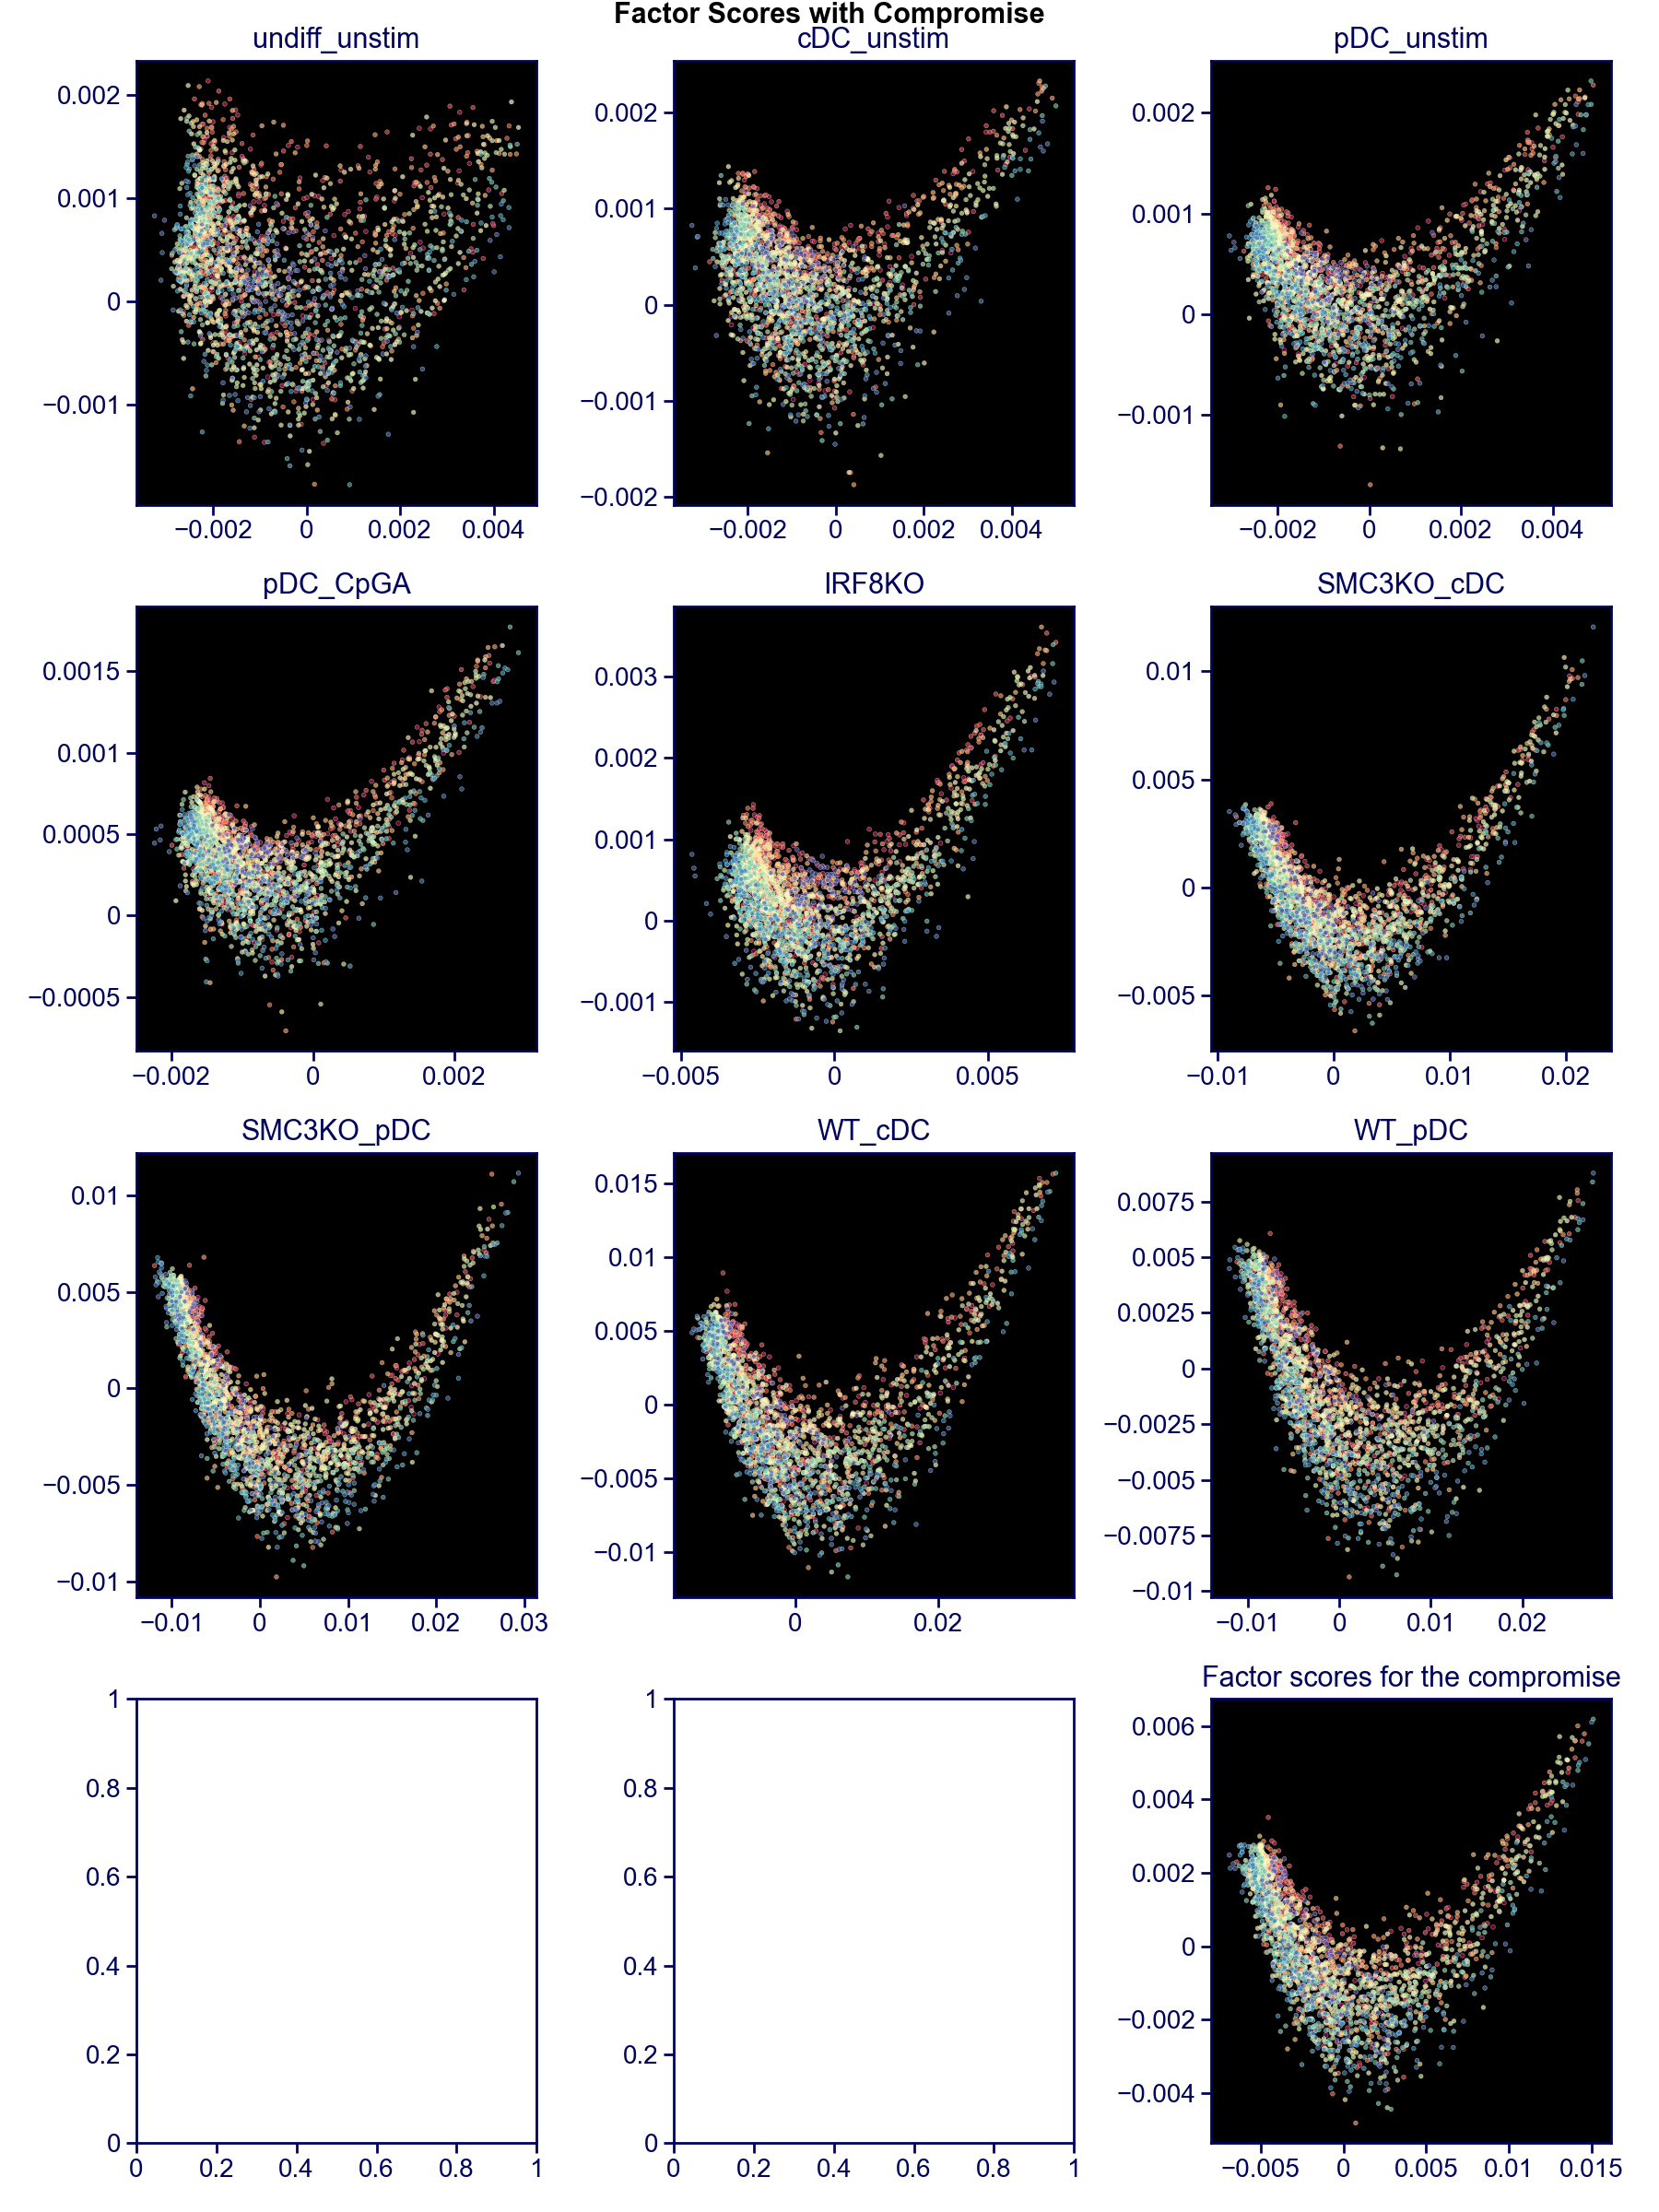

In [13]:
joint_lib.summary_STATIS(OUTPUT_STATIS, CONDITIONS, 10, COMP_TARGET=1)

In [14]:
OUTPUT_STATIS.factor_scores_.shape

(2396, 128)

### Store the output

In [20]:
CHROMSIZES = bioframe.fetch_chromsizes('mm10', filter_chroms=True)[:'chrY']
CHROMOSOMES = list(CHROMSIZES[:'chrY'].index)
BINSIZE = 1_000_000

bins = cooler.binnify(CHROMSIZES, BINSIZE)
# clr = cooler.Cooler(COOLER_PATHS[CONDITIONS[0]]+f"::/resolutions/{BINSIZE}")

In [21]:
N_COMP = 10
bins, variance_explained = joint_lib.parse_statis_output(OUTPUT_STATIS, bins, CONDITIONS, good_bins=GOOD_BINS, n_comp=N_COMP+1)

In [22]:
reference = bins.loc[:, 'consensus-dimension:0':'consensus-dimension:10'].values

In [23]:
# Project to the consensus and store the output:
for cond in CONDITIONS:
    proj = joint_lib.projection(COOLERS_DICT[cond], reference, n_comp=N_COMP, normalize=False)

    cols = [f'proj:{cond}:{i}' for i in range(N_COMP+1)]
    bins.loc[:, cols] = proj

In [24]:
# Project to the consensus and store the output:
for cond in CONDITIONS:
    
    proj = joint_lib.transform(COOLERS_DICT[cond], reference, variance_explained, whiten=True)

    cols = [f'transformed:{cond}:{i}' for i in range(N_COMP+1)]
    bins.loc[:, cols] = proj

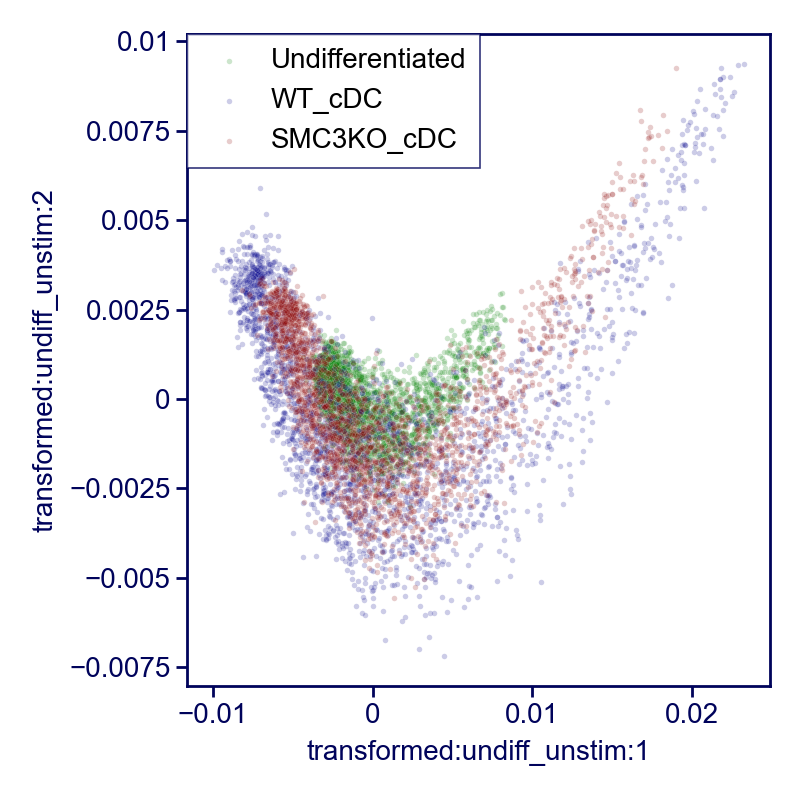

In [35]:
sns.scatterplot(
    x='transformed:undiff_unstim:1',
    y='transformed:undiff_unstim:2',
    data=bins,
    color='green',
    s=4,
    alpha=0.2,
    label="Undifferentiated",
)

sns.scatterplot(
    x='transformed:WT_cDC:1',
    y='transformed:WT_cDC:2',
    data=bins,
    color='darkblue',
    s=4,
    alpha=0.2,
    label="WT_cDC",
)

sns.scatterplot(
    x='transformed:SMC3KO_cDC:1',
    y='transformed:SMC3KO_cDC:2',
    data=bins,
    color='darkred',
    s=4,
    alpha=0.2,
    label="SMC3KO_cDC",
)

# ax.set_facecolor('black')
plt.legend()
plt.tight_layout()

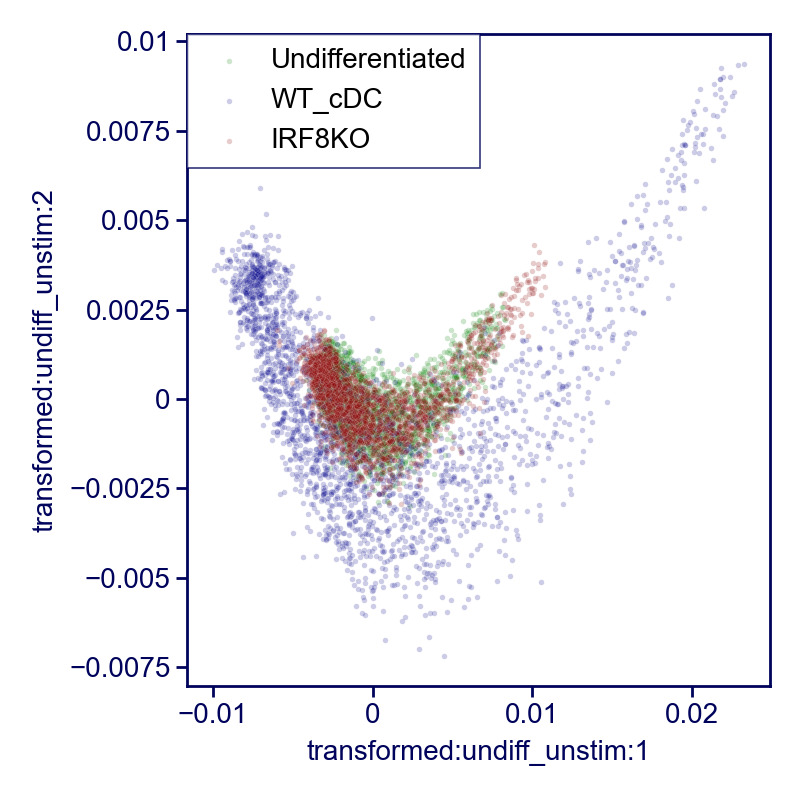

In [36]:
sns.scatterplot(
    x='transformed:undiff_unstim:1',
    y='transformed:undiff_unstim:2',
    data=bins,
    color='green',
    s=4,
    alpha=0.2,
    label="Undifferentiated",
)

sns.scatterplot(
    x='transformed:WT_cDC:1',
    y='transformed:WT_cDC:2',
    data=bins,
    color='darkblue',
    s=4,
    alpha=0.2,
    label="WT_cDC",
)

sns.scatterplot(
    x='transformed:IRF8KO:1',
    y='transformed:IRF8KO:2',
    data=bins,
    color='darkred',
    s=4,
    alpha=0.2,
    label="IRF8KO",
)

# ax.set_facecolor('black')
plt.legend()
plt.tight_layout()

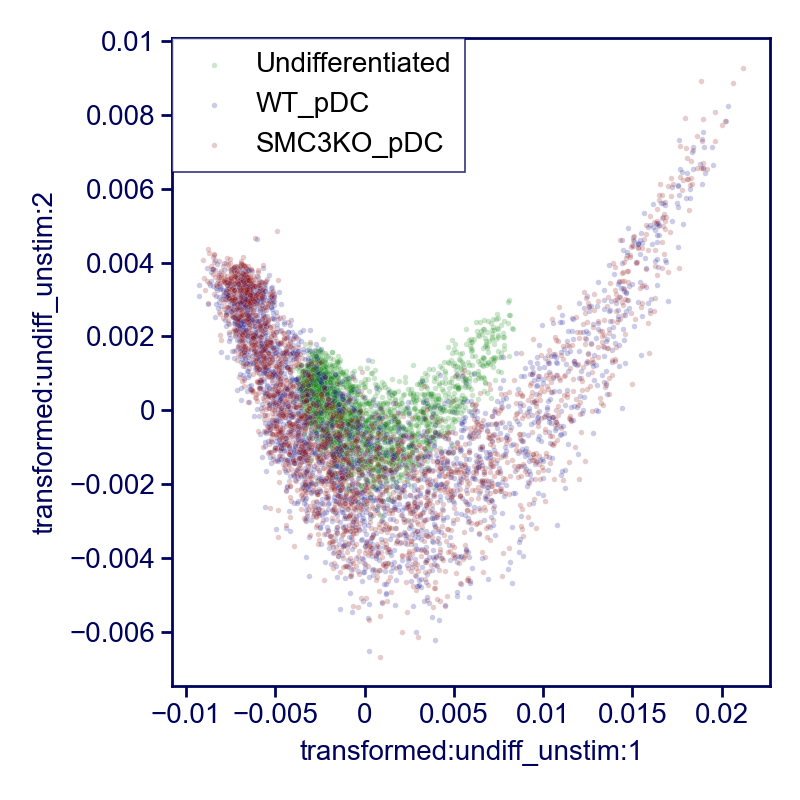

In [37]:
sns.scatterplot(
    x='transformed:undiff_unstim:1',
    y='transformed:undiff_unstim:2',
    data=bins,
    color='green',
    s=4,
    alpha=0.2,
    label="Undifferentiated",
)

sns.scatterplot(
    x='transformed:WT_pDC:1',
    y='transformed:WT_pDC:2',
    data=bins,
    color='darkblue',
    s=4,
    alpha=0.2,
    label="WT_pDC",
)

sns.scatterplot(
    x='transformed:SMC3KO_pDC:1',
    y='transformed:SMC3KO_pDC:2',
    data=bins,
    color='darkred',
    s=4,
    alpha=0.2,
    label="SMC3KO_pDC",
)

# ax.set_facecolor('black')
plt.legend()
plt.tight_layout()

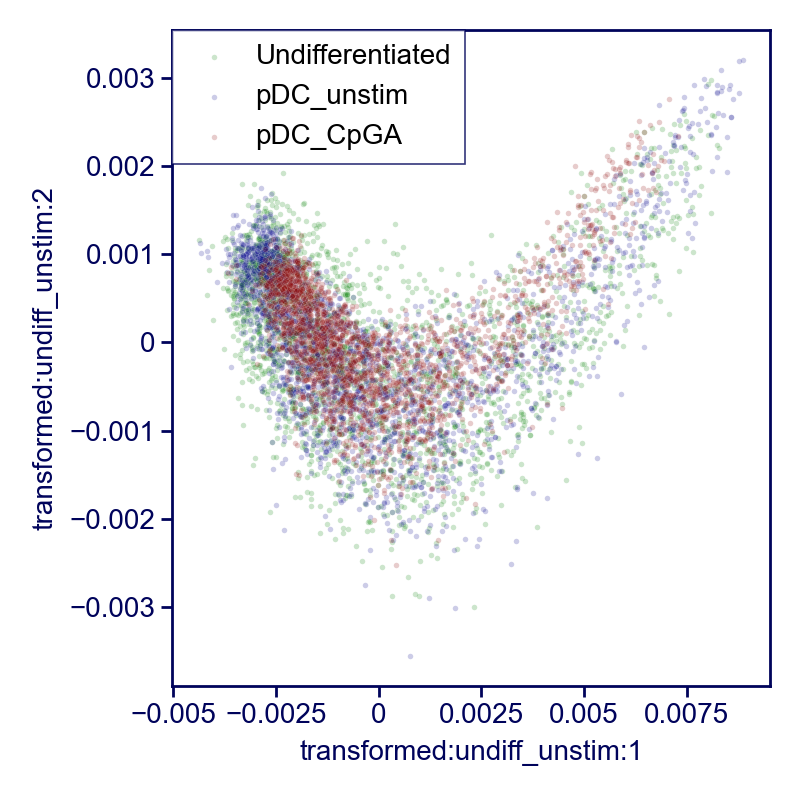

In [42]:
sns.scatterplot(
    x='transformed:undiff_unstim:1',
    y='transformed:undiff_unstim:2',
    data=bins,
    color='green',
    s=4,
    alpha=0.2,
    label="Undifferentiated",
)

sns.scatterplot(
    x='transformed:pDC_unstim:1',
    y='transformed:pDC_unstim:2',
    data=bins,
    color='darkblue',
    s=4,
    alpha=0.2,
    label="pDC_unstim",
)

sns.scatterplot(
    x='transformed:pDC_CpGA:1',
    y='transformed:pDC_CpGA:2',
    data=bins,
    color='darkred',
    s=4,
    alpha=0.2,
    label="pDC_CpGA",
)

# ax.set_facecolor('black')
plt.legend()
plt.tight_layout()

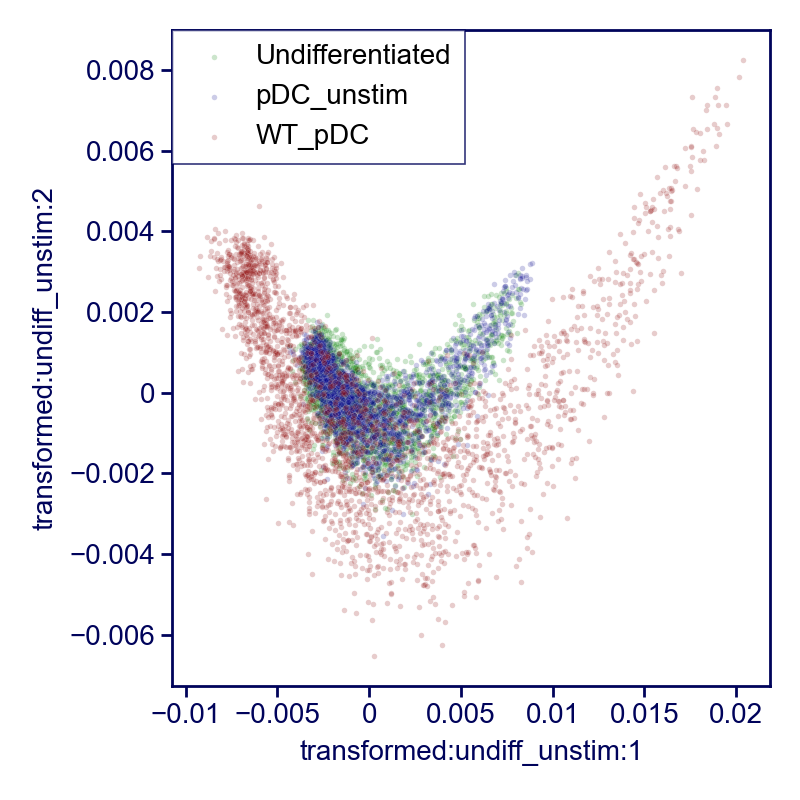

In [41]:
sns.scatterplot(
    x='transformed:undiff_unstim:1',
    y='transformed:undiff_unstim:2',
    data=bins,
    color='green',
    s=4,
    alpha=0.2,
    label="Undifferentiated",
)

sns.scatterplot(
    x='transformed:pDC_unstim:1',
    y='transformed:pDC_unstim:2',
    data=bins,
    color='darkblue',
    s=4,
    alpha=0.2,
    label="pDC_unstim",
)

sns.scatterplot(
    x='transformed:WT_pDC:1',
    y='transformed:WT_pDC:2',
    data=bins,
    color='darkred',
    s=4,
    alpha=0.2,
    label="WT_pDC",
)

# ax.set_facecolor('black')
plt.legend()
plt.tight_layout()

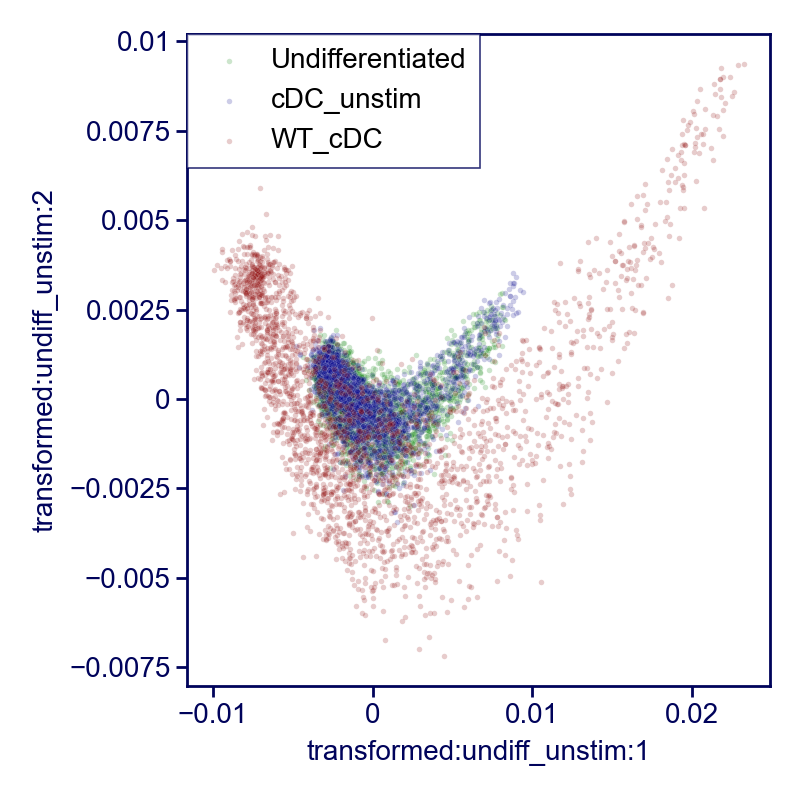

In [44]:
sns.scatterplot(
    x='transformed:undiff_unstim:1',
    y='transformed:undiff_unstim:2',
    data=bins,
    color='green',
    s=4,
    alpha=0.2,
    label="Undifferentiated",
)

sns.scatterplot(
    x='transformed:cDC_unstim:1',
    y='transformed:cDC_unstim:2',
    data=bins,
    color='darkblue',
    s=4,
    alpha=0.2,
    label="cDC_unstim",
)

sns.scatterplot(
    x='transformed:WT_cDC:1',
    y='transformed:WT_cDC:2',
    data=bins,
    color='darkred',
    s=4,
    alpha=0.2,
    label="WT_cDC",
)

# ax.set_facecolor('black')
plt.legend()
plt.tight_layout()